<font size = "5"> **Chapter 1: [Introduction](CH1_00-Introduction.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Open DM3 Images, Spectra, Spectrum-Images and  Image-Stacks with pyNSID 

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Introduction/CH1_04-Open_File.ipynb)
 



part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

---
Reading a dm file and translating the data in a **[pyNSID](https://pycroscopy.github.io/pyNSID/)** style hf5py file to be compatible with  the **[pycroscopy](https://pycroscopy.github.io/pycroscopy/)** package.

Because, many other packages and programs for TEM data manipulation are based on the ``hdf5`` file-formats it is relatively easy to convert back and forward between them.



## Import packages for figures and
### Check Installed Packages

In [2]:
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError):
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2023.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Load the plotting and figure packages

In [4]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
%gui qt

import pyTEMlib
import pyTEMlib.file_tools  as ft     # File input/ output library

import sidpy
import pyNSID
import h5py

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__='CH1_04-Reading_File'
__notebook_version__='2021_12_14'

pyTEM version:  0.2023.1.0


## Open a file 

This function opens a hfd5 file in the pyNSID style which enables you to keep track of your data analysis.

Please see the **[Installation](CH1_02-Prerequisites.ipynb#TEM-Library)** notebook for installation.

We want to consolidate files into one dataset that belongs together.  For example a spectrum image dataset consists of: 
* Survey image, 
* EELS spectra 
* Z-contrast image acquired simultaneously with the spectra.


So load the top dataset first in the above example the survey image.

Please note that the plotting routine of ``matplotlib`` was introduced in **[Matplotlib and Numpy for Micrographs](CH1_03-Data_Representation.ipynb)** notebook.

**Use the file p1-3hr.dm3 from TEM_data directory for a practice run**

In [5]:
# ------ Input ------- #
load_example = False
# -------------------- #

# Open file widget and select file which will be opened in code cell below
if not load_example:
    drive_directory = ft.get_last_path()
    file_widget = ft.FileWidget(drive_directory)

Select(description='Select file:', layout=Layout(width='70%'), options=('.',), rows=10, value='.')

directory moved since last time read


<IPython.core.display.Javascript object>


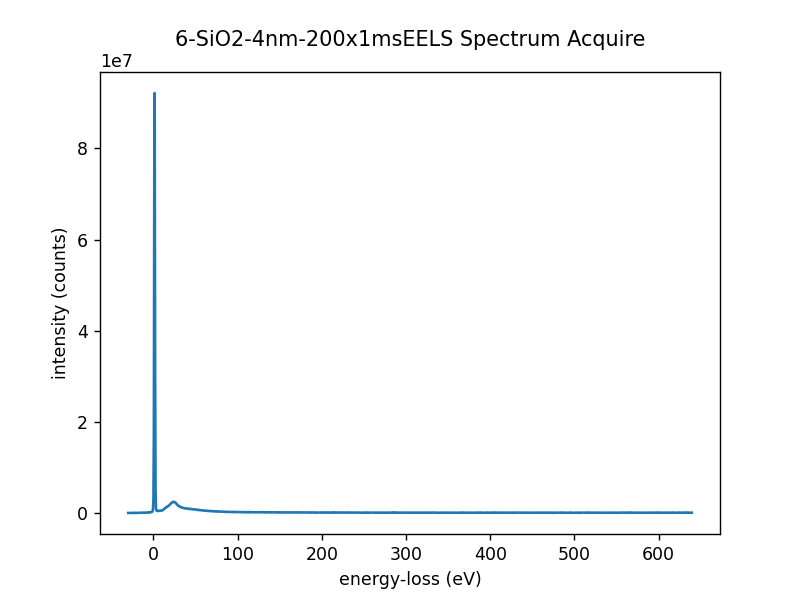

In [7]:
try:
    main_dataset.h5_dataset.file.close()
except:
    pass

if load_example:
    file_name = '../example_data/p1-3-hr3.dm3'
else:
    file_name = file_widget.file_name

datasets = ft.open_file(file_name)
main_dataset = datasets['Channel_000']

view = main_dataset.plot()

## Data Structure

The data themselves reside in a ``sidpy dataset`` which we name ``current_dataset``.

The current_dataset has additional information stored as attributes which can be accessed through their name.

In [8]:
print(main_dataset)
main_dataset

sidpy.Dataset of type SPECTRUM with:
 dask.array<array, shape=(1340,), dtype=float32, chunksize=(1340,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (1340,)
 with metadata: ['experiment', 'filename']


sidpy.Dataset of type SPECTRUM with:
 dask.array<array, shape=(1340,), dtype=float32, chunksize=(1340,), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
energy_loss:  energy-loss (eV) of size (1340,)
 with metadata: ['experiment', 'filename']

In [9]:
print(f'size of current dataset is {main_dataset.shape}')

size of current dataset is (1340,)


The current_dataset has additional information stored as attributes which can be accessed through their name.

There are two dictionaries within that attributes:
- **metadata**
- **original_metadata**

which contain additional information about the data

In [15]:
print('title: ', main_dataset.title)
print('data type: ', main_dataset.data_type)

for key in datasets:
    print(key)
    print(datasets[key].original_metadata.keys())
    
main_dataset.metadata  

title:  6-SiO2-4nm-200x1msEELS Spectrum Acquire
data type:  DataType.SPECTRUM
Channel_000
dict_keys(['ImageData', 'ImageTags', 'Name', 'UniqueID', 'DM', 'original_filename', 'ApplicationBounds', 'DocumentObjectList', 'DocumentTags', 'HasWindowPosition', 'Image Behavior', 'ImageSourceList', 'InImageMode', 'MinVersionList', 'NextDocumentObjectID', 'Page Behavior', 'SentinelList', 'Thumbnails', 'WindowPosition', 'original_title'])


{'experiment': {'single_exposure_time': 0.001,
  'exposure_time': 0.2,
  'number_of_frames': 200,
  'collection_angle': 50.0,
  'convergence_angle': 30.0,
  'microscope': 'UltraSTEM 60 kV',
  'acceleration_voltage': 100000.0},
 'filename': 'C:\\Users\\gduscher\\Documents\\Github\\MSE672-Introduction-to-TEM\\example_data\\6-SiO2.dm3'}

## Data Structure
The datasets variable is a dictionary (like a directory in a file system) which containes contains datasets.

Below I show how to access one of those datasets with a pull down menu.

In [18]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: 6-SiO2-4nm-200x1msEELS Spectrum Acquire',), val…

<IPython.core.display.Javascript object>


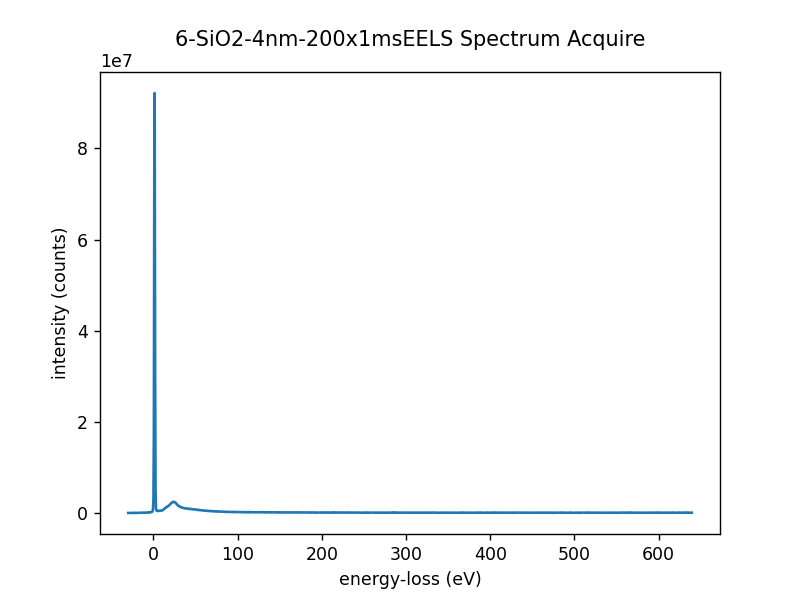

In [23]:
current_dataset = chooser.dataset
view = current_dataset.plot()

An important attribute in ``current_dataset`` is the ``original_metadata`` group, where all the original metadata of your file reside in the ``attributes``. This is usually a long list for ``dm3`` files.

In [24]:
current_dataset.original_metadata.keys()

dict_keys(['ImageData', 'ImageTags', 'Name', 'UniqueID', 'DM', 'original_filename', 'ApplicationBounds', 'DocumentObjectList', 'DocumentTags', 'HasWindowPosition', 'Image Behavior', 'ImageSourceList', 'InImageMode', 'MinVersionList', 'NextDocumentObjectID', 'Page Behavior', 'SentinelList', 'Thumbnails', 'WindowPosition', 'original_title'])

The original_metadata attribute has all information stored from the orginal file. 
> No information will get lost

In [25]:
for key,value in current_dataset.original_metadata.items():
    print(key, value)
print(current_dataset.h5_dataset)    

ImageData {'Calibrations': {'Brightness': {'Origin': 0.0, 'Scale': 1.0, 'Units': 'Counts'}, 'Dimension': {'0': {'Origin': 60.0, 'Scale': 0.5, 'Units': 'eV'}}, 'DisplayCalibratedUnits': 1}, 'Data': 'read', 'DataType': 2, 'Dimensions': {'0': 1340}, 'PixelDepth': 4}
ImageTags {'Acquisition': {'Device': {'Active Size (pixels)': [1340, 100], 'Camera Number': 0, 'CCD': {'Pixel Size (um)': [20.0, 20.0]}, 'Configuration': {'Transpose': {'Diagonal Flip': 0, 'Horizontal Flip': 0, 'Vertical Flip': 0}}, 'Name': 'Enfina 1000 1', 'Source': 'Enfina 1000 1'}, 'Frame': {'Area': {'Transform': {'Class Name': 'cm_acquisitiontransform_list', 'Transform List': {'0': {'Binning': [1, 1], 'Class Name': 'cm_acquisitiontransform', 'Sub Area Adjust': [0, 0, 0, 0], 'Transpose': {'Diagonal Flip': 0, 'Horizontal Flip': 0, 'Vertical Flip': 0}}}}}, 'CCD': {'Pixel Size (um)': [20.0, 20.0]}, 'Intensity': {'Transform': {'Class Name': 'cm_valuetransform_list', 'Transform List': {'0': {'Class Name': 'cm_valuetransform_affi

Any python object will provide a help.

In [28]:
help(current_dataset)

Help on Dataset in module sidpy.sid.dataset object:

class Dataset(dask.array.core.Array)
 |  Dataset(*args, **kwargs)
 |  
 |  ..autoclass::Dataset
 |  
 |  To instantiate from an existing array-like object,
 |  use :func:`Dataset.from_array` - requires numpy array, list or tuple
 |  
 |  This dask array is extended to have the following attributes:
 |  -data_type: DataTypes ('image', 'image_stack',  spectral_image', ...
 |  -units: str
 |  -quantity: str what kind of data ('intensity', 'height', ..)
 |  -title: title of the data set
 |  -modality: character of data such as 'STM, 'AFM', 'TEM', 'SEM', 'DFT', 'simulation', ..)
 |  -source: origin of data such as acquisition instrument ('Nion US100', 'VASP', ..)
 |  -_axes: dictionary of Dimensions one for each data dimension
 |                  (the axes are dimension datasets with name, label, units,
 |                  and 'dimension_type' attributes).
 |  
 |  -metadata: dictionary of additional metadata
 |  -original_metadata: dicti

All attributes of a python object can be viewed with the * dir* command. 
> As above: too much information for normal use, but it is there if needed.

In [29]:
dir(current_dataset)

['A',
 'T',
 '_Array__chunks',
 '_Array__name',
 '_Dataset__rearrange_axes',
 '_Dataset__reduce_dimensions',
 '_Dataset__validate_dim',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_function__',
 '__array_priority__',
 '__array_ufunc__',
 '__await__',
 '__bool__',
 '__class__',
 '__complex__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos

## Adding Data

To add another dataset that belongs to this measurement we will use the **h5_add_channel** from  **file_tools** in the  pyTEMlib package.

Here is how we add a channel there.

We can also add a new measurement group (add_measurement in pyTEMlib) for similar datasets.

This is equivalent to making a new directory in a file structure on your computer.

In [30]:
datasets['Copied_of_Channel_000'] = current_dataset.copy()

We use above functions to add the content of a (random) data-file to the current file.

This is important if you for example want to add a Z-contrast or survey-image to a spectrum image.

Therefore, these functions enable you to collect the data from different files that belong together.


In [32]:
datasets.keys()

dict_keys(['Channel_000', 'Copied_of_Channel_000'])

## Adding additional information

Similarly, we can add a whole new measurement group or a structure group.

This function will be contained in the KinsCat package of pyTEMlib.

If you loaded the example image, with graphite and ZnO both are viewed in the [1,1,1] zone axis.


In [35]:
import pyTEMlib.kinematic_scattering as ks         # kinematic scattering Library
                             # with Atomic form factors from Kirkland's book
import ase

                                                                                 
graphite = ks.structure_by_name('Graphite')
print(graphite)

Atoms(symbols='C4', pbc=False, cell=[[2.46772414, 0.0, 0.0], [-1.2338620699999996, 2.1371117947721068, 0.0], [0.0, 0.0, 6.711]])


In [ ]:
current_dataset.structures['Crystal_000'] = graphite
                                                            
zinc_oxide = ks.structure_by_name('ZnO')
current_dataset.structures['ZnO'] =zinc_oxide               


## Keeping Track of Analysis and Results
A notebook is notorious for getting confusing, especially if one uses different notebooks for different task, but store them in the same file.

If you like a result of your calculation, log it.

Use the datasets dictionary to add a analysed and/or modified dataset. Make sure the metadata contain all the necessary information, so that you will know later what you did.

The convention in this class will be to call the dataset **Log_000**.


In [37]:
new_dataset = current_dataset.T
new_dataset.metadata = {'analysis': 'Nothing', 'name': 'Nothing'}
datasets['Log_000'] = new_dataset

## An example for a log
We log the Fourier Transform of the image we loaded

First we perform the calculation

<IPython.core.display.Javascript object>


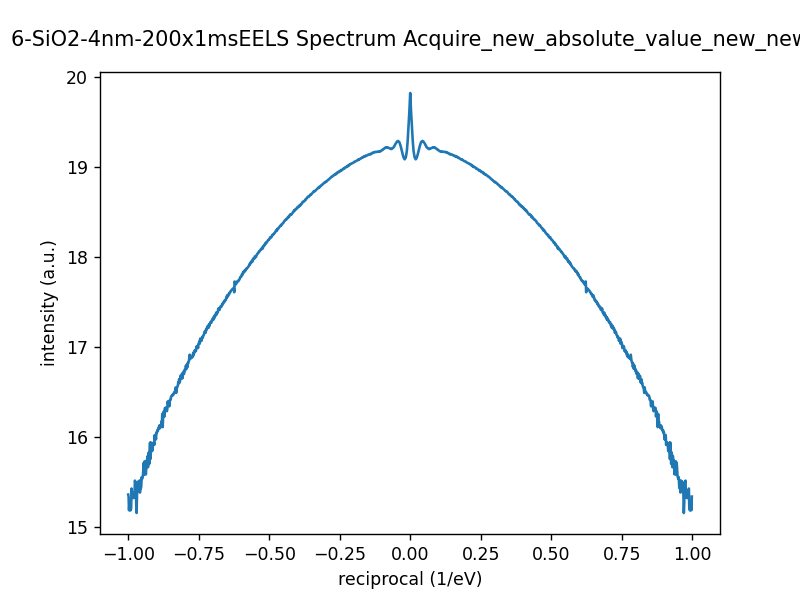

In [38]:
fft_image = current_dataset.fft().abs()
fft_image = np.log(60+fft_image)

view = fft_image.plot()

Now that we like this we log it.

Please note that just saving the fourier transform would not be good as we also need the scale and such.

<IPython.core.display.Javascript object>


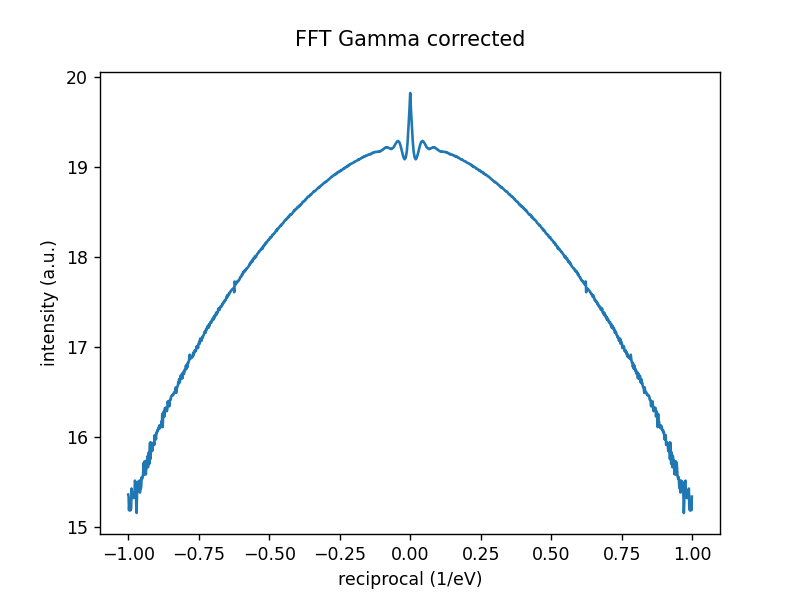

In [41]:
fft_image.title = 'FFT Gamma corrected'
fft_image.metadata = {'analysis': 'fft'}
datasets['Log_001'] = fft_image

view = fft_image.plot()

We added quite a few datasets to our dictionary. 

Let's have a look


In [42]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: 6-SiO2-4nm-200x1msEELS Spectrum Acquire', 'Copi…

<IPython.core.display.Javascript object>


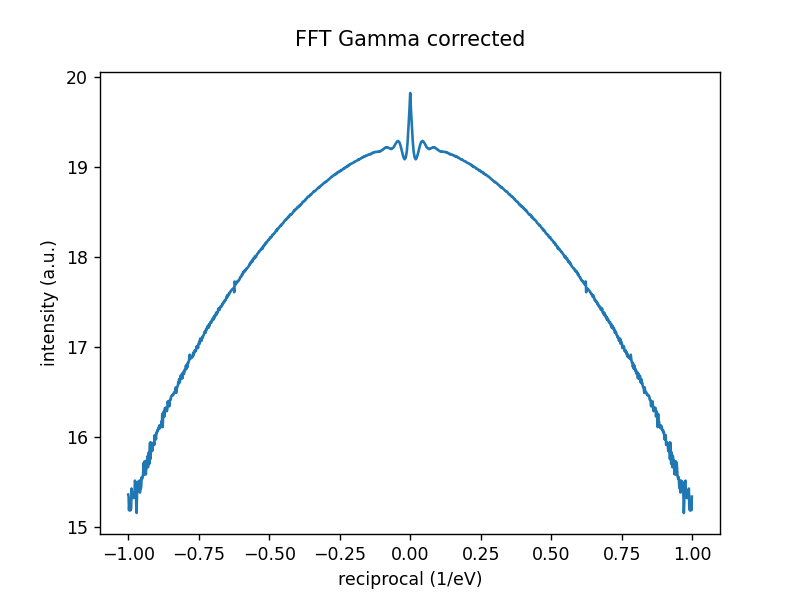

In [43]:
view = chooser.dataset.plot()

## Save Datasets to  hf5_file
Write all datasets to one h5_file, which we then close immediatedly

In [49]:
filename

'C:/Users/gduscher/Documents/Github/MSE672-Introduction-to-TEM/example_data/niw.hf5'

In [50]:
h5_group = ft.save_dataset(datasets, filename='./nix.hf5')
h5_group.file.close()

C:\Users\gduscher\Anaconda3\envs\tem\Lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:6-SiO2-4nm-200x1msEELS Spectrum Acquire to 6_SiO2_4nm_200x1msEELS Spectrum Acquire
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\Anaconda3\envs\tem\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\Anaconda3\envs\tem\Lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:6-SiO2-4nm-200x1msEELS Spectrum Acquire to 6_SiO2_4nm_200x1msEELS Spectrum Acquire
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\Anaconda3\envs\tem\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be r

In [ ]:
Close the file

## Open h5_file
Open the h5_file that we just created

In [55]:
datasets2= ft.open_file(filename='./nix.hf5')

#chooser = ft.ChooseDataset(datasets2)

experiment
DM
DocumentObjectList
0
AnnotationGroupList
ImageDisplayInfo
CalibrationSliceId
DimensionLabels
GroupList
0
GroupToDisplay
MainSliceId
SliceList
0
ImageToGroup
SliceId
ObjectTags
DocumentTags
Image Behavior
UnscaledTransform
ZoomAndMoveTransform
ImageData
Calibrations
Brightness
Dimension
0
Dimensions
ImageSourceList
0
Extra Slice Info
0
Id
Id
ImageTags
Acquisition
Device
CCD
Configuration
Transpose
Frame
Area
Transform
Transform List
0
Transpose
CCD
Intensity
Transform
Transform List
0
1
2
Parameters
Base Detector
Detector
PICM Parameters
000220
000247
Vertical Skips
Environment
High Level
Shutter
Transform
Objects
0
1
2
3
EELS
Acquisition
Spectrometer
Experimental Conditions
Meta Data
Microscope Info
Items
0
1
2
MinVersionList
0
Page Behavior
PageTransform
SentinelList
Thumbnails
0
UniqueID
experiment


### Short check if we got the data right
we print the tree and we plot the data

<IPython.core.display.Javascript object>


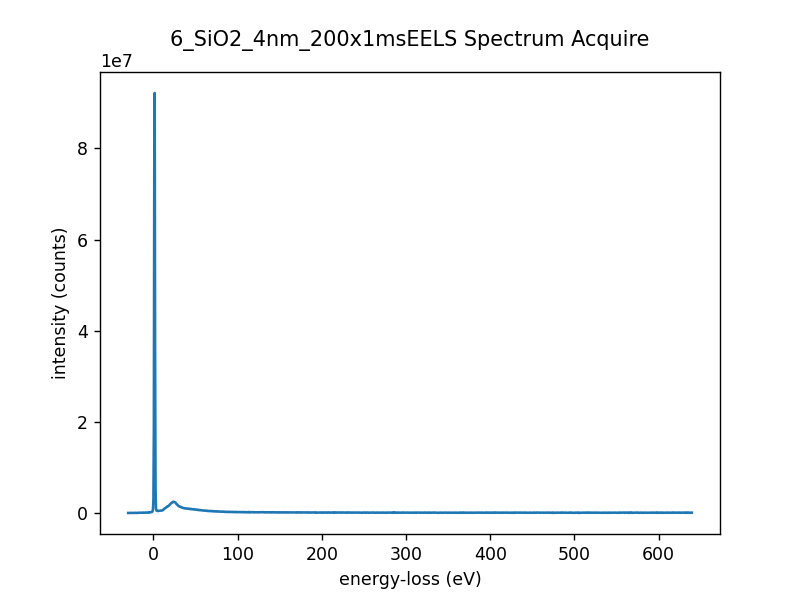

In [53]:
view = chooser.dataset.plot()


## Navigation
- <font size = "3">  **Back  [Matplotlib and Numpy for Micrographs](CH1_03-Data_Representation.ipynb)** </font>
- <font size = "3">  **Next: [Overview](CH1_06-Overview.ipynb)** </font>
- <font size = "3">  **Chapter 1: [Introduction](CH1_00-Introduction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>
